/home/ysc/.local/share/virtualenvs/bdphysics-24hdeN5V/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


BP = 0.376
Tn = 256.2
Td = 0.5
fc obj = 0.071


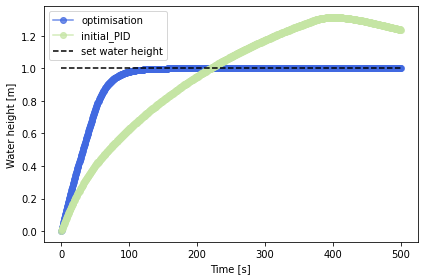

In [1]:
# quelques couleurs
rouge_A = '#C60C2E'
vert1_A = '#005157'
vert2_A = '#627D77'
vert3_A = '#9EB28F'
vert4_A = '#C5E5A4'
medblue = 'royalblue'
gris1_A = '#595A5C'
coule = [rouge_A, vert1_A, vert2_A, vert3_A, vert4_A, medblue, gris1_A]
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize


# solve for the water height with Crank-Nicolson's scheme
def fc_CN(hp, h, dt, A, B):
    return -hp + h + 0.5 * (dt * (A - B * np.sqrt(h))) + 0.5 * (dt * (A - B * np.sqrt(hp)))
# a function to chose the shape of the valve curve
def fc_valve_curve(characteristic, valve_pos, Qmax):
    if characteristic == "linear":
        Qsupply = Qmax * valve_pos
    elif characteristic == "equal_pct":
        Qsupply = Qmax * np.exp(3.5 * (valve_pos - 1))
    elif characteristic == "quadratic":
        Qsupply = Qmax * valve_pos ** 2
    return Qsupply

characteristic = "linear"
# characteristic="equal_pct"
# characteristics="quadratic"

# Geometrical data
Pi = 3.14159269  # pi
Dr = 1  # m tank diameter
Ds = 0.04  # m outlet diameter
Sr = Pi * Dr ** 2 / 4  # m2 tank surface
Ss = Pi * Ds ** 2 / 4  # m2 outlet surface
H0 = 1  # m tank height

# PID parameters
prop_band = 0.5  # m proportional band
Kp = 1 / prop_band  # gain
Tn = 500  # integration time
Td = 0  # derivation time
Qmax = 15  # max flow rate L/s
Qmax = Qmax / 1000  # conversion to m3/s
f_init = 0.
# time and timestep
t = 0
dt = 0.5  # [s] time step /sampling rate
B = Ss / Sr * np.sqrt(2 * 9.81)  # precompute B, constant in the equation for h

# the function to be minimised
def run_pid_simulation(pid_params):

    BP, Tn, Td = pid_params[0], pid_params[1], pid_params[2] # get the PID's parameters
    Kp = 1 / BP
    # initial values
    h = f_init * H0  # m height =set point height
    Qsupply = 0  # no flow rate initially
    sim_time = 500  # simulation duration s
    time, height, v_pos = [], [], []
    t = 0
    # Remise à zero des paramètres de calcul de la regulation
    sum_error = 0
    delta_error = 0
    valve_position = 0
    deltaT_previous = 0
    while t <= sim_time:
        # Crank-Nicolson semi-implicit for water height
        A = Qsupply / Sr  # compute A
        h = fsolve(fc_CN, h, args=(h, dt, A, B))[0]
        # integral action
        sum_error = dt / Tn * (H0 - h) + sum_error
        # derivative action
        delta_error = (H0 - h) - deltaT_previous
        # computation of the valve position with PID
        valve_position = Kp * ((H0 - h) + sum_error + Td * delta_error / dt)
        # Control for valve opening
        if valve_position < 0.:
            valve_position = 0
            Qsupply = 0
        elif valve_position > 1:
            valve_position = 1
            Qsupply = Qmax
        else:
            Qsupply = fc_valve_curve(characteristic, valve_position, Qmax)
        deltaT_previous = H0 - h
        t += dt
        time.append(t)
        height.append(h)
        v_pos.append(valve_position)
    v_pos = np.asarray(v_pos)
    height_set = H0 * np.ones(len(height))
    diff = np.asarray(height) - height_set
    diff = abs(diff)
    mean_diff = np.mean(diff)

    return mean_diff, time, height, v_pos

def compute_loss(height, v_pos):
    # penalize the result if
    penalty = 0
    idx0 = np.where(v_pos == 0)
    if len(idx0[0]) > 10:
        penalty += 100

    # compute gradient
    i = int(len(v_pos) / 2)
    v = v_pos[i:-2]
    vp = v_pos[i + 1:-1]
    md = np.mean(abs(vp - v))
    if md > 0.02:
        penalty += 100
    height_set = H0 * np.ones(len(height))
    diff = np.asarray(height) - height_set
    diff = abs(diff)
    mean_diff = np.mean(diff)
    return mean_diff + penalty

def fc_to_minimize_wloss(x):
    _, _, height, v_pos = run_pid_simulation(x)
    return compute_loss(height,v_pos)

# bounds of the parameters
#       prop.band , integration & derivation times
bnds = ((0.1, 0.6), (5, 500) , (0.5, 100))

k = 0.5 # starting point between the bounds for each parameter
x0 = [k * (bnds[0][0] + bnds[0][1]),
      k * (bnds[1][0] + bnds[1][1]),
      k * (bnds[2][0] + bnds[2][1])]

objective_0, time_0, height_0, v_pos_0 = run_pid_simulation(x0)

sol = minimize(fc_to_minimize_wloss, x0, bounds=bnds, method='TNC', tol=1e-3)

# let us plot the result
BP, Tn, Td = sol.x[0], sol.x[1], sol.x[2]
objective, time, height, v_pos = run_pid_simulation([BP, Tn, Td])

print("BP =", round(BP, 3))
print("Tn =", round(Tn, 1))
print("Td =", round(Td, 1))
print("fc obj =", round(objective, 3))

time = np.asarray(time)
time = time - dt

plt.xlabel("Time [s]")
plt.ylabel("Water height [m]")
plt.plot(time, height, color=coule[-2], linestyle="-", alpha=0.75, marker='o', label='optimisation')
plt.plot(time, height_0, color=coule[-3], linestyle="-", alpha=0.75, marker='o', label='initial_PID')
plt.plot(time, np.ones(len(time)) * H0, color='black', linestyle="--", alpha=0.9985, marker='',label='set water height')

plt.legend()
plt.tight_layout()
plt.show()